In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import argrelmin, argrelmax

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

import inspect

Using TensorFlow backend.


In [2]:
#Check Versions
print(tf.__version__)  #1.15.0
print(keras.__version__)  #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{(1-f(x_{T,i},\theta'))}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

We will now parametrize our network by giving it a $\mu$ value in addition to $X_i\sim\mathcal{N}(\mu, 1)$.

First we uniformly sample $\mu$ values in some range

In [3]:
n_data_points = 10**6
mu_min = -2
mu_max = 2
mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

We then sample from normal distributions with this $\mu$ value

In [4]:
X0 = [(np.random.normal(0, 1), mu)
      for mu in mu_values]  # Note the zero in normal(0, 1)
X1 = [(np.random.normal(mu, 1), mu) for mu in mu_values]

Please note that the samples in X0 are not paired with $\mu=0$ as this would make the task trivial. 

Instead it is paired with the $\mu$ values uniformly sampled in the specified range [mu_min, mu_max].

For every value of $\mu$ in mu_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

In [5]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Build Model

In [6]:
inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs=inputs, outputs=outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

## Train DCTR model

In [7]:
earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
dctr_model.fit(X_train,
               Y_train,
               epochs=200,
               batch_size=10000,
               validation_data=(X_test, Y_test),
               callbacks=[earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1600000 samples, validate on 400000 samples
Epoch 1/200





1600000/1600000 [==============================] - 4s 2us/step - loss: 0.5805 - val_loss: 0.5647
Epoch 2/200
1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5631 - val_loss: 0.5621
Epoch 3/200
1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5622 - val_loss: 0.5617
Epoch 4/200
1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5621 - val_loss: 0.5620
Epoch 5/200
1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5621 - val_loss: 0.5618
Epoch 6/200
1600000/1600000 [==============================] - 2s 2us/step - loss: 0.5620 - val_loss: 0.5619
Epoch 7/200
1600000/1600000 [==============================] - 2s 2us/step - loss: 0.5621 - val_loss: 0.5616
Epoch 8/200
1600000/1600000 [==============================] - 3s 2us/step - loss:

## Saving Model

In [8]:
'''
model_json = dctr_model.to_json()
with open("1d_gaussian_dctr_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dctr_model.save_weights("1d_gaussian_dctr_model.h5")
print("Saved model to disk")
'''

'\nmodel_json = dctr_model.to_json()\nwith open("1d_gaussian_dctr_model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\ndctr_model.save_weights("1d_gaussian_dctr_model.h5")\nprint("Saved model to disk")\n'

### Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [9]:
# from NN (DCTR)
def reweight(events, param):

    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=events.shape) * param
    #combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)

    f = dctr_model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights


# from analytical formula for normal distributions
def analytical_reweight(events, param):
    mu0 = 0.0
    weights = K.exp(-(0.5 * (events - param)**2) + (0.5 * (events - mu0)**2))
    return weights

# Alternative Fit

## Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

To apply detector effects, each event $x_{T,i}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,\epsilon)$,where $\epsilon$ represents the smearing. Thus: $x_{D,i} = x_{T,i} + Z_{i}$

In [10]:
N = 10**6
theta0_param = 0  # this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1  # this is the data (the target)
sigma = 1.  # Gaussian width
epsilon = sigma / 2  # Smearing width

theta0_T = np.random.normal(theta0_param, sigma, N)  #Truth Level Data
theta0_D = np.array([(x + np.random.normal(0, epsilon))
                     for x in theta0_T])  #Detector smearing
theta0 = np.stack([theta0_T, theta0_D], axis=1)

theta1_T = np.random.normal(theta1_param, sigma, N)
theta1_D = np.array([(x + np.random.normal(0, epsilon))
                     for x in theta1_T])  #Detector smearing
theta1 = np.stack([theta1_T, theta0_D], axis=1)

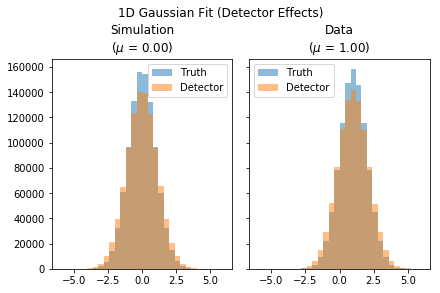

In [11]:
bins = np.linspace(-6, 6, 31)

fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('1D Gaussian Fit (Detector Effects)')

axs[0].set_title("Simulation\n($\mu$ = {:.2f})".format(theta0_param))
axs[0].hist(theta0_T, bins=bins, alpha=0.5, label='Truth')
axs[0].hist(theta0_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend()

axs[1].set_title("Data\n($\mu$ = {:.2f})".format(theta1_param))
axs[1].hist(theta1_T, bins=bins, alpha=0.5, label='Truth')
axs[1].hist(theta1_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend()

#fig.savefig("1D Gaussian: Data ($\mu$ = {:.2f}) w detector effects.png".format(theta1_param))
plt.show()

In [12]:
#'Erasing' Truth level for data, we can't actually observe this
theta1 = np.stack([np.zeros_like(theta0_D), theta0_D], axis=1)

In [13]:
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0_D, theta1_D])
y_true = np.concatenate([labels0, labels1])
# 'hiding' truth level for simulation in model output (used in reweighting)
truth_level = np.concatenate([theta0_T, theta1_T])
yvals = np.stack([y_true, truth_level], axis=1)

X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)

X_train_theta, y_train_theta = shuffle(xvals, yvals)

## Fitting Model: Scan

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Loading Model

In [14]:
# load json and create model
'''
json_file = open('dctr_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dctr_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
dctr_model.load_weights("dctr_model.h5")
print("Loaded model from disk")
'''

'\njson_file = open(\'dctr_model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\ndctr_model = keras.models.model_from_json(loaded_model_json)\n# load weights into new model\ndctr_model.load_weights("dctr_model.h5")\nprint("Loaded model from disk")\n'

### Creating Model

In [15]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 500


def my_loss_wrapper(val=0, reweight_analytically=False, MSE_loss=True):
    def my_loss(y_true, y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size))
        y_labels = tf.gather(y_true, [0], axis=1)  # actual y_true for loss
        x_T = tf.gather(y_true, [1], axis=1)  # sim event truth for reweighting

        theta_prime = val

        if reweight_analytically:
            # analytical reweight
            weights = analytical_reweight(x_T, theta_prime)
        else:
            #NN reweight
            weights = analytical_reweight(x_T, theta_prime)
        if MSE_loss:
            # Mean Squared Loss
            t_loss = y_labels * (y_labels - y_pred)**2 + (weights) * (
                1. - y_labels) * (y_labels - y_pred)**2
        else:
            # Categorical Cross-Entropy Loss
            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_labels) * K.log(y_pred) + weights *
                       (1 - y_labels) * K.log(1 - y_pred))

        return K.mean(t_loss)

    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


### Training Model

In [16]:
thetas = np.linspace(-2, 2, 21)
lvals = []
vlvals = []

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper(theta, MSE_loss=False),
                  metrics=['accuracy'])
    model.fit(np.array(X_train),
              y_train,
              epochs=100,
              batch_size=batch_size,
              validation_data=(np.array(X_test), y_test),
              verbose=1,
              callbacks=[earlystopping])
    lvals += [np.min(model.history.history['loss'])]
    vlvals += [np.min(model.history.history['val_loss'])]
    print
    pass
print(lvals)

testing theta = : -2.0
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2217 - acc: 0.3098 - val_loss: 0.2185 - val_acc: 0.3107
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2180 - acc: 0.3093 - val_loss: 0.2182 - val_acc: 0.3114
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2179 - acc: 0.3093 - val_loss: 0.2181 - val_acc: 0.3098
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2180 - acc: 0.3093 - val_loss: 0.2180 - val_acc: 0.3100
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2179 - acc: 0.3093 - val_loss: 0.2181 - val_acc: 0.3099
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2179 - acc: 0.3093 - val_loss: 0.2181 - val_acc: 0.3087
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - 

Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.4049 - acc: 0.3281 - val_loss: 0.4051 - val_acc: 0.3285
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.4049 - acc: 0.3280 - val_loss: 0.4050 - val_acc: 0.3286
Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.4049 - acc: 0.3281 - val_loss: 0.4052 - val_acc: 0.3284
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.4049 - acc: 0.3282 - val_loss: 0.4051 - val_acc: 0.3284
testing theta = : -0.7999999999999998
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.4467 - acc: 0.3302 - val_loss: 0.4468 - val_acc: 0.3319
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.4467 - acc: 0.3307 - val_loss: 0.4467 - val_acc: 0.3308
Epoch 3/100
1000000/1000000 [==============================

Epoch 16/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6023 - acc: 0.3361 - val_loss: 0.6023 - val_acc: 0.3364
testing theta = : 0.20000000000000018
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.6332 - acc: 0.3357 - val_loss: 0.6330 - val_acc: 0.3359
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6332 - acc: 0.3357 - val_loss: 0.6331 - val_acc: 0.3362
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6332 - acc: 0.3357 - val_loss: 0.6330 - val_acc: 0.3357
Epoch 4/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6332 - acc: 0.3357 - val_loss: 0.6330 - val_acc: 0.3359
Epoch 5/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6332 - acc: 0.3357 - val_loss: 0.6331 - val_acc: 0.3359
Epoch 6/100
1000000/1000000 [==============================

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6776 - acc: 0.1790 - val_loss: 0.6766 - val_acc: 0.1805
testing theta = : 1.6
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.6588 - acc: 0.1820 - val_loss: 0.6574 - val_acc: 0.1792
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6587 - acc: 0.1820 - val_loss: 0.6574 - val_acc: 0.1814
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6587 - acc: 0.1824 - val_loss: 0.6575 - val_acc: 0.1860
Epoch 4/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6586 - acc: 0.1827 - val_loss: 0.6573 - val_acc: 0.1828
Epoch 5/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6586 - acc: 0.1828 - val_loss: 0.6573 - val_acc: 0.1839
Epoch 6/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.658

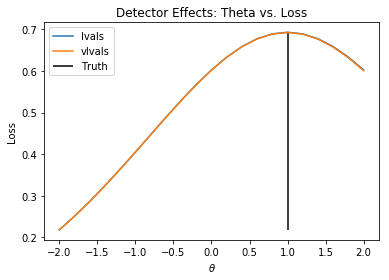

In [17]:
plt.plot(thetas, lvals, label='lvals')
plt.plot(thetas, vlvals, label='vlvals')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param, ymin=np.min(lvals), ymax=np.max(lvals), label='Truth')
plt.title("Detector Effects: Theta vs. Loss")
plt.legend()
#plt.savefig("Detector Effects: Theta vs. Loss.png")
plt.show()

We've shown for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

## Building and Training Fitting Model: Gradient Fit

In [18]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(
    ". theta fit = ", model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(
    on_epoch_end=lambda batch, logs: fit_vals.append(model_fit.layers[-1].
                                                     get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)

In [19]:
myinputs_fit = Input(shape=(1, ))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers) - 1].add_weight(
    name="thetaX",
    shape=list(),
    initializer=keras.initializers.Constant(value=theta_fit_init),
    trainable=True)
model_fit.summary()

batch_size = 2 * N
iterations = 50

# optimizer will be refined as fit progresses for better precision
lr_initial = 5e-1
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])


def my_loss_wrapper_fit(mysign=1, reweight_analytically=False, MSE_loss=True):
    def my_loss(y_true, y_pred):
        # Getting theta0:
        if mysign == 1:
            # when not training theta, fetch as np array
            theta0 = model_fit.layers[-1].get_weights()
            # regular batch size
            y_true = tf.gather(y_true, np.arange(1000))
        else:
            # when trainingn theta, fetch as tf.Variable
            theta0 = model_fit.trainable_weights[-1]
            # special theta batch size
            y_true = tf.gather(y_true, np.arange(batch_size))

        y_labels = tf.gather(y_true, [0], axis=1)  # actual y_true for loss
        x_T = tf.gather(y_true, [1], axis=1)  # sim truth for reweighting

        if reweight_analytically:
            # analytical reweight
            weights = analytical_reweight(x_T, theta0)
        else:
            # NN reweight
            weights = reweight(x_T, theta0)

        if MSE_loss:
            # Mean Squared Loss
            t_loss = mysign * (y_labels * (y_labels - y_pred)**2 + weights *
                               (1. - y_labels) * (y_labels - y_pred)**2)
        else:
            # Categorical Cross-Entropy Loss
            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -mysign * ((y_labels) * K.log(y_pred) + weights *
                                (1 - y_labels) * K.log(1 - y_pred))

        return K.mean(t_loss)

    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 1         
Total params: 16,898
Trainable params: 16,898
Non-trainable params: 0
_________________________________________________________________


In [20]:
for iteration in range(iterations):
    print("Iteration: ", iteration)
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    # regular optimizer and batch size
    model_fit.compile(optimizer=keras.optimizers.Adam(),
                      loss=my_loss_wrapper_fit(1, MSE_loss=False),
                      metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train),
                  y_train,
                  epochs=100,
                  batch_size=1000,
                  validation_data=(np.array(X_test), y_test),
                  verbose=1,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit(-1, MSE_loss=False),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta),
                  y_train_theta,
                  epochs=1,
                  batch_size=batch_size,
                  verbose=1,
                  callbacks=callbacks)

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior

    extrema = np.concatenate(
        (argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema", extrema)
    '''

    if (len(extrema) == 0
        ):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema) >= 6):  # If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10.
    pass

Iteration:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.5990 - acc: 0.3359 - val_loss: 0.5985 - val_acc: 0.3364
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.5985 - acc: 0.3362 - val_loss: 0.5987 - val_acc: 0.3363
Epoch 3/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.5985 - acc: 0.3362 - val_loss: 0.5983 - val_acc: 0.3363
Epoch 4/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.5985 - acc: 0.3360 - val_loss: 0.5984 - val_acc: 0.3363
Epoch 5/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.5984 - acc: 0.3361 - val_loss: 0.5984 - val_acc: 0.3363
Epoch 6/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.5984 - acc: 0.3361 - val_loss: 0.5983 - val_acc: 0.3364
Epoch 7/100
1000000/1000000 [==============================] - 6s 6us/step 

1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6638 - acc: 0.3345 - val_loss: 0.6637 - val_acc: 0.3351
Epoch 20/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6638 - acc: 0.3346 - val_loss: 0.6635 - val_acc: 0.3338
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 6s 3us/step - loss: -0.6636 - acc: 0.3348
. theta fit =  0.8720451
Iteration:  2
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6886 - acc: 0.3275 - val_loss: 0.6879 - val_acc: 0.3321
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6883 - acc: 0.3310 - val_loss: 0.6878 - val_acc: 0.3307
Epoch 3/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6883 - acc: 0.3312 - val_loss: 0.6878 - val_acc: 0.3329
Epoch 4/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0

1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6893 - acc: 0.3291 - val_loss: 0.6889 - val_acc: 0.3308
Epoch 20/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6893 - acc: 0.3307 - val_loss: 0.6889 - val_acc: 0.3319
Epoch 21/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6893 - acc: 0.3306 - val_loss: 0.6889 - val_acc: 0.3329
Epoch 22/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6893 - acc: 0.3305 - val_loss: 0.6892 - val_acc: 0.3359
Epoch 23/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6893 - acc: 0.3310 - val_loss: 0.6889 - val_acc: 0.3328
Epoch 24/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6893 - acc: 0.3305 - val_loss: 0.6889 - val_acc: 0.3326
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 6s 3us/step - loss: -0.6891 - acc: 0.3320
. theta fit =  1.1736066
Iteration:  5
Trai

1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6903 - acc: 0.1743 - val_loss: 0.6899 - val_acc: 0.1667
Epoch 11/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6903 - acc: 0.1740 - val_loss: 0.6898 - val_acc: 0.1800
Epoch 12/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6903 - acc: 0.1747 - val_loss: 0.6897 - val_acc: 0.1727
Epoch 13/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6903 - acc: 0.1748 - val_loss: 0.6897 - val_acc: 0.1731
Epoch 14/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6903 - acc: 0.1748 - val_loss: 0.6897 - val_acc: 0.1741
Epoch 15/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6903 - acc: 0.1747 - val_loss: 0.6897 - val_acc: 0.1771
Epoch 16/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6903 - acc: 0.1744 - val_loss: 0.6897 - val_acc: 0.1758
Epoch 17/100
100000

1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6904 - acc: 0.1736 - val_loss: 0.6898 - val_acc: 0.1758
Epoch 13/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6904 - acc: 0.1736 - val_loss: 0.6899 - val_acc: 0.1669
Epoch 14/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6904 - acc: 0.1737 - val_loss: 0.6898 - val_acc: 0.1679
Epoch 15/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6904 - acc: 0.1733 - val_loss: 0.6899 - val_acc: 0.1678
Epoch 16/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6904 - acc: 0.1736 - val_loss: 0.6899 - val_acc: 0.1675
Epoch 17/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6904 - acc: 0.1733 - val_loss: 0.6898 - val_acc: 0.1738
Epoch 18/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6904 - acc: 0.1734 - val_loss: 0.6898 - val_acc: 0.1695
Training theta
Epoc

1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6920 - acc: 0.1738 - val_loss: 0.6914 - val_acc: 0.1706
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 7s 3us/step - loss: -0.6917 - acc: 0.1720
. theta fit =  1.0657527
Iteration:  13
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.6922 - acc: 0.1754 - val_loss: 0.6916 - val_acc: 0.1678
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6922 - acc: 0.1739 - val_loss: 0.6916 - val_acc: 0.1706
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1745 - val_loss: 0.6916 - val_acc: 0.1731
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1745 - val_loss: 0.6916 - val_acc: 0.1838
Epoch 5/100
1000000/1000000 [==============================] - 6s 6us/step - loss:

. theta fit =  1.066007
Iteration:  17
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.6922 - acc: 0.1729 - val_loss: 0.6916 - val_acc: 0.1718
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6922 - acc: 0.1725 - val_loss: 0.6917 - val_acc: 0.1639
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1727 - val_loss: 0.6916 - val_acc: 0.1811
Epoch 4/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6922 - acc: 0.1731 - val_loss: 0.6916 - val_acc: 0.1665
Epoch 5/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6922 - acc: 0.1736 - val_loss: 0.6916 - val_acc: 0.1727
Epoch 6/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6922 - acc: 0.1728 - val_loss: 0.6916 - val_acc: 0.1727
Epoch 7/100
1000000/1000000 [===================

Epoch 25/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1717 - val_loss: 0.6916 - val_acc: 0.1781
Epoch 26/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1727 - val_loss: 0.6916 - val_acc: 0.1702
Epoch 27/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1717 - val_loss: 0.6916 - val_acc: 0.1858
Epoch 28/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1735 - val_loss: 0.6916 - val_acc: 0.1662
Epoch 29/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1716 - val_loss: 0.6916 - val_acc: 0.1873
Epoch 30/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1727 - val_loss: 0.6916 - val_acc: 0.1797
Epoch 31/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1744 - val_loss: 0.6916 - val_acc: 0.1818
Epoch 

Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1734 - val_loss: 0.6917 - val_acc: 0.1654
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1733 - val_loss: 0.6917 - val_acc: 0.1672
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1755 - val_loss: 0.6917 - val_acc: 0.1680
Epoch 5/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1724 - val_loss: 0.6917 - val_acc: 0.1686
Epoch 6/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1725 - val_loss: 0.6917 - val_acc: 0.1640
Epoch 7/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1732 - val_loss: 0.6917 - val_acc: 0.1641
Epoch 8/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1732 - val_loss: 0.6917 - val_acc: 0.1657
Epoch 9/100
1

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1750 - val_loss: 0.6917 - val_acc: 0.1975
Epoch 21/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1763 - val_loss: 0.6917 - val_acc: 0.1651
Epoch 22/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1721 - val_loss: 0.6917 - val_acc: 0.2009
Epoch 23/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1741 - val_loss: 0.6917 - val_acc: 0.1660
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 8s 4us/step - loss: -0.6919 - acc: 0.1666
. theta fit =  1.0512863
Iteration:  26
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 12s 12us/step - loss: 0.6922 - acc: 0.1756 - val_loss: 0.6917 - val_acc: 0.1662
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - lo

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1733 - val_loss: 0.6917 - val_acc: 0.1645
Epoch 9/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1705 - val_loss: 0.6917 - val_acc: 0.1661
Epoch 10/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1711 - val_loss: 0.6917 - val_acc: 0.1638
Epoch 11/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1687 - val_loss: 0.6917 - val_acc: 0.1648
Epoch 12/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1720 - val_loss: 0.6917 - val_acc: 0.1664
Epoch 13/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1740 - val_loss: 0.6917 - val_acc: 0.1643
Epoch 14/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1740 - val_loss: 0.6917 - val_acc: 0.1866
Epoch 15/100
1000000

. theta fit =  1.048176
Iteration:  32
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 13s 13us/step - loss: 0.6922 - acc: 0.1712 - val_loss: 0.6917 - val_acc: 0.1900
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1758 - val_loss: 0.6917 - val_acc: 0.1646
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1754 - val_loss: 0.6917 - val_acc: 0.2112
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1757 - val_loss: 0.6917 - val_acc: 0.1787
Epoch 5/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1743 - val_loss: 0.6917 - val_acc: 0.1865
Epoch 6/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1753 - val_loss: 0.6917 - val_acc: 0.1822
Epoch 7/100
1000000/1000000 [===================

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1772 - val_loss: 0.6917 - val_acc: 0.1637
Epoch 8/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1723 - val_loss: 0.6917 - val_acc: 0.1789
Epoch 9/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1745 - val_loss: 0.6917 - val_acc: 0.1666
Epoch 10/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1750 - val_loss: 0.6917 - val_acc: 0.1643
Epoch 11/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1745 - val_loss: 0.6917 - val_acc: 0.1821
Epoch 12/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1774 - val_loss: 0.6917 - val_acc: 0.1642
Epoch 13/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1768 - val_loss: 0.6917 - val_acc: 0.1662
Epoch 14/100
1000000/

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1766 - val_loss: 0.6917 - val_acc: 0.1651
Epoch 14/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1739 - val_loss: 0.6917 - val_acc: 0.1647
Epoch 15/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1716 - val_loss: 0.6917 - val_acc: 0.1644
Epoch 16/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1721 - val_loss: 0.6917 - val_acc: 0.1805
Epoch 17/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1729 - val_loss: 0.6917 - val_acc: 0.1882
Epoch 18/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1772 - val_loss: 0.6917 - val_acc: 0.1637
Epoch 19/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1743 - val_loss: 0.6917 - val_acc: 0.1647
Epoch 20/100
100000

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1768 - val_loss: 0.6917 - val_acc: 0.2082
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 10s 5us/step - loss: -0.6919 - acc: 0.1664
. theta fit =  1.0469238
Iteration:  42
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 14s 14us/step - loss: 0.6922 - acc: 0.1740 - val_loss: 0.6917 - val_acc: 0.1981
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1771 - val_loss: 0.6917 - val_acc: 0.1844
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1751 - val_loss: 0.6917 - val_acc: 0.1639
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6922 - acc: 0.1770 - val_loss: 0.6917 - val_acc: 0.1650
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss

1000000/1000000 [==============================] - 15s 15us/step - loss: 0.6922 - acc: 0.1806 - val_loss: 0.6917 - val_acc: 0.1636
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1662 - val_loss: 0.6917 - val_acc: 0.1711
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1765 - val_loss: 0.6917 - val_acc: 0.1652
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1724 - val_loss: 0.6917 - val_acc: 0.1685
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1735 - val_loss: 0.6917 - val_acc: 0.1660
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1732 - val_loss: 0.6917 - val_acc: 0.1651
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1717 - val_loss: 0.6917 - val_acc: 0.1980
Epoch 8/100
1000000/100

Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1816 - val_loss: 0.6917 - val_acc: 0.1642
Epoch 13/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1739 - val_loss: 0.6917 - val_acc: 0.1835
Epoch 14/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1765 - val_loss: 0.6917 - val_acc: 0.1643
Epoch 15/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1781 - val_loss: 0.6917 - val_acc: 0.1645
Epoch 16/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1774 - val_loss: 0.6917 - val_acc: 0.1653
Epoch 17/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1748 - val_loss: 0.6917 - val_acc: 0.1666
Epoch 18/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6922 - acc: 0.1763 - val_loss: 0.6917 - val_acc: 0.1662
Epoch 

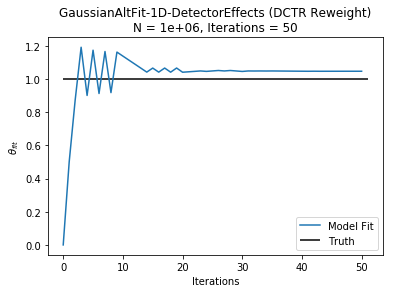

In [21]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(theta1_param, 0, len(fit_vals), label='Truth')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("GaussianAltFit-1D-DetectorEffects (DCTR Reweight)\n" +
          "N = {:.0e}, Iterations = {:.0f}".format(N, iterations))
# plt.savefig("GaussianAltFit-1D-DetectorEffects (DCTR Reweight)" +
#             "N = {:.0e}, Iterations = {:.0f}.png".format(N, iterations))
plt.show()

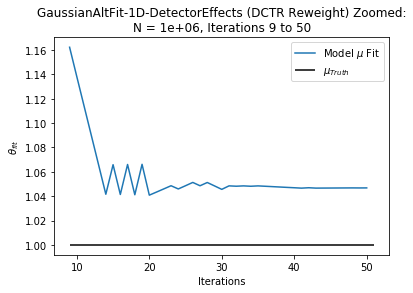

In [22]:
# Zoom into later iterations (finer fit)
fit_vals = np.array(fit_vals)
plt.title("GaussianAltFit-1D-DetectorEffects (DCTR Reweight) Zoomed:\n" +
          "N = {:.0e}, Iterations {:.0f} to {:.0f}".format(
              N, index_refine[1], iterations))
plt.plot(np.arange(index_refine[1], len(fit_vals)),
         fit_vals[index_refine[1]:],
         label='Model $\mu$ Fit')
plt.hlines(theta1_param, index_refine[1], len(fit_vals), label='$\mu_{Truth}$')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig("GaussianAltFit-1D-DetectorEffects (DCTR Reweight) Zoomed:" +
#             "N = {:.0e}, Iterations {:.0f} to {:.0f}.png".format(
#                 N, index_refine[1], iterations))
plt.show()

### Compare with analytical reweight.

In [23]:
fit_vals = [theta_fit_init]
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

In [24]:
for iteration in range(iterations):
    print("Iteration: ", iteration)
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    # regular optimizer and batch size
    model_fit.compile(optimizer=keras.optimizers.Adam(),
                      loss=my_loss_wrapper_fit(1,
                                               reweight_analytically=True,
                                               MSE_loss=False),
                      metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train),
                  y_train,
                  epochs=100,
                  batch_size=1000,
                  validation_data=(np.array(X_test), y_test),
                  verbose=1,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit(-1,
                                               reweight_analytically=True,
                                               MSE_loss=False),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta),
                  y_train_theta,
                  epochs=1,
                  batch_size=batch_size,
                  verbose=1,
                  callbacks=callbacks)

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior

    extrema = np.concatenate(
        (argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema", extrema)
    '''

    if (len(extrema) == 0
        ):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema) >= 6):  # If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10.
    pass

Iteration:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 16s 16us/step - loss: 0.6930 - acc: 0.1720 - val_loss: 0.6924 - val_acc: 0.1660
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6929 - acc: 0.1722 - val_loss: 0.6924 - val_acc: 0.1719
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6929 - acc: 0.1724 - val_loss: 0.6924 - val_acc: 0.1729
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6930 - acc: 0.1727 - val_loss: 0.6924 - val_acc: 0.1689
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6930 - acc: 0.1710 - val_loss: 0.6924 - val_acc: 0.1682
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6929 - acc: 0.1726 - val_loss: 0.6924 - val_acc: 0.1694
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/ste

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6731 - acc: 0.3335 - val_loss: 0.6729 - val_acc: 0.3322
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 10s 5us/step - loss: -0.6730 - acc: 0.3334
. theta fit =  0.9190014
Iteration:  2
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 16s 16us/step - loss: 0.6931 - acc: 0.3335 - val_loss: 0.6920 - val_acc: 0.3343
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6925 - acc: 0.3311 - val_loss: 0.6920 - val_acc: 0.3294
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6925 - acc: 0.3294 - val_loss: 0.6920 - val_acc: 0.3318
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6925 - acc: 0.3291 - val_loss: 0.6920 - val_acc: 0.3266
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss:

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6929 - acc: 0.3255 - val_loss: 0.6924 - val_acc: 0.3364
Epoch 18/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6929 - acc: 0.3278 - val_loss: 0.6924 - val_acc: 0.3360
Epoch 19/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6929 - acc: 0.3262 - val_loss: 0.6924 - val_acc: 0.3355
Epoch 20/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6929 - acc: 0.3270 - val_loss: 0.6924 - val_acc: 0.3127
Epoch 21/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6929 - acc: 0.3263 - val_loss: 0.6924 - val_acc: 0.3231
Epoch 22/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6929 - acc: 0.3272 - val_loss: 0.6924 - val_acc: 0.3175
Epoch 23/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6929 - acc: 0.3266 - val_loss: 0.6924 - val_acc: 0.3171
Epoch 24/100
100000

1000000/1000000 [==============================] - 17s 17us/step - loss: 0.6938 - acc: 0.1876 - val_loss: 0.6927 - val_acc: 0.1769
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6931 - acc: 0.2709 - val_loss: 0.6928 - val_acc: 0.2542
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6931 - acc: 0.3123 - val_loss: 0.6925 - val_acc: 0.3347
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6931 - acc: 0.3222 - val_loss: 0.6925 - val_acc: 0.3250
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6931 - acc: 0.3199 - val_loss: 0.6925 - val_acc: 0.3341
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6931 - acc: 0.3233 - val_loss: 0.6925 - val_acc: 0.3363
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6931 - acc: 0.3255 - val_loss: 0.6925 - val_acc: 0.3193
Epoch 8/100
1000000/100

Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 17s 17us/step - loss: 0.6906 - acc: 0.1745 - val_loss: 0.6899 - val_acc: 0.1706
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6906 - acc: 0.1744 - val_loss: 0.6899 - val_acc: 0.1728
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6906 - acc: 0.1745 - val_loss: 0.6899 - val_acc: 0.1778
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6906 - acc: 0.1743 - val_loss: 0.6899 - val_acc: 0.1719
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6906 - acc: 0.1746 - val_loss: 0.6899 - val_acc: 0.1787
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6906 - acc: 0.1751 - val_loss: 0.6899 - val_acc: 0.1724
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6906 - acc: 0

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.1739 - val_loss: 0.6913 - val_acc: 0.1819
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.1744 - val_loss: 0.6913 - val_acc: 0.1706
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.1738 - val_loss: 0.6913 - val_acc: 0.1782
Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.1744 - val_loss: 0.6913 - val_acc: 0.1713
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.1735 - val_loss: 0.6913 - val_acc: 0.1826
Epoch 13/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.1739 - val_loss: 0.6913 - val_acc: 0.1746
Epoch 14/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.1739 - val_loss: 0.6913 - val_acc: 0.1756
Epoch 15/100
1000000

1000000/1000000 [==============================] - 18s 18us/step - loss: 0.6930 - acc: 0.1756 - val_loss: 0.6925 - val_acc: 0.1642
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6930 - acc: 0.1749 - val_loss: 0.6924 - val_acc: 0.1772
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6930 - acc: 0.1782 - val_loss: 0.6924 - val_acc: 0.1717
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6930 - acc: 0.1753 - val_loss: 0.6924 - val_acc: 0.1801
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6930 - acc: 0.1766 - val_loss: 0.6925 - val_acc: 0.1638
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6930 - acc: 0.1757 - val_loss: 0.6924 - val_acc: 0.1737
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6930 - acc: 0.1750 - val_loss: 0.6924 - val_acc: 0.1679
Epoch 8/100
1000000/100

Epoch 25/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.3127 - val_loss: 0.6926 - val_acc: 0.3362
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.6929 - acc: 0.3304
. theta fit =  1.0150506
Iteration:  19
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 19s 19us/step - loss: 0.6932 - acc: 0.2364 - val_loss: 0.6926 - val_acc: 0.1819
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.1915 - val_loss: 0.6926 - val_acc: 0.2296
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.1857 - val_loss: 0.6926 - val_acc: 0.1648
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6931 - acc: 0.1904 - val_loss: 0.6926 - val_acc: 0.1637
Epoch 5/100
1000000/1000000 [==============================] - 8s 8u

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.3120 - val_loss: 0.6926 - val_acc: 0.3358
Epoch 37/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.3158 - val_loss: 0.6926 - val_acc: 0.3288
Epoch 38/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.3055 - val_loss: 0.6926 - val_acc: 0.3339
Epoch 39/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.3082 - val_loss: 0.6926 - val_acc: 0.3166
Epoch 40/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.3100 - val_loss: 0.6926 - val_acc: 0.2704
Epoch 41/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.3032 - val_loss: 0.6926 - val_acc: 0.3087
Epoch 42/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.3009 - val_loss: 0.6926 - val_acc: 0.3356
Epoch 43/100
100000

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.1814 - val_loss: 0.6926 - val_acc: 0.1946
Epoch 15/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6931 - acc: 0.1892 - val_loss: 0.6926 - val_acc: 0.1673
Epoch 16/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6931 - acc: 0.1888 - val_loss: 0.6926 - val_acc: 0.1662
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 13s 6us/step - loss: -0.6929 - acc: 0.1712
. theta fit =  0.9891108
====Refining Learning Rate====
Iteration:  24
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 19s 19us/step - loss: 0.6932 - acc: 0.2318 - val_loss: 0.6926 - val_acc: 0.2951
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2965 - val_loss: 0.6926 - val_acc: 0.3262
Epoch 3/100
1000000/1000000 [===================

Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2910 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2651 - val_loss: 0.6926 - val_acc: 0.2515
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2788 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2753 - val_loss: 0.6926 - val_acc: 0.2872
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2831 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2561 - val_loss: 0.6926 - val_acc: 0.2503
Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2614 - val_loss: 0.6926 - val_acc: 0.3264
Epoch 12/10

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2667 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2451 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2480 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2501 - val_loss: 0.6927 - val_acc: 0.2499
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2483 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 11/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2455 - val_loss: 0.6926 - val_acc: 0.2504
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6932 - acc: 0.2533 - val_loss: 0.6926 - val_acc: 0.2501
Training theta
Epoch 1

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2776 - val_loss: 0.6927 - val_acc: 0.2501
Epoch 8/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2765 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 9/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2745 - val_loss: 0.6926 - val_acc: 0.3223
Epoch 10/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2642 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 11/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2886 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 12/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2881 - val_loss: 0.6926 - val_acc: 0.3364
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.6929 - acc: 0.3193
. theta fit =  0.99952614
====Refining Learn

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2658 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 5/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2521 - val_loss: 0.6926 - val_acc: 0.2529
Epoch 6/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2712 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 7/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2658 - val_loss: 0.6927 - val_acc: 0.2501
Epoch 8/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2543 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 9/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2587 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 10/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2528 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 11/100
1000000/100

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2639 - val_loss: 0.6926 - val_acc: 0.2502
Epoch 7/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2743 - val_loss: 0.6926 - val_acc: 0.2507
Epoch 8/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2692 - val_loss: 0.6926 - val_acc: 0.2516
Epoch 9/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2674 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 10/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2576 - val_loss: 0.6926 - val_acc: 0.3039
Epoch 11/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2652 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 12/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2678 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 13/100
1000000/1

Epoch 14/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2501 - val_loss: 0.6926 - val_acc: 0.2501
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.6929 - acc: 0.2500
. theta fit =  0.99706507
Iteration:  42
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 21s 21us/step - loss: 0.6932 - acc: 0.2499 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2500 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2501 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 4/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2502 - val_loss: 0.6927 - val_acc: 0.2499
Epoch 5/100
1000000/1000000 [==============================] - 9s 9

Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.6929 - acc: 0.2500
. theta fit =  0.9960793
Iteration:  45
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 22s 22us/step - loss: 0.6932 - acc: 0.2501 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2500 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2500 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 4/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2499 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 5/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2504 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 6/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2499 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 10/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2498 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 11/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2500 - val_loss: 0.6926 - val_acc: 0.2501
Epoch 12/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2497 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 13/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2502 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 14/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2497 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 15/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6932 - acc: 0.2498 - val_loss: 0.6926 - val_acc: 0.2499
Epoch 16/100
100000

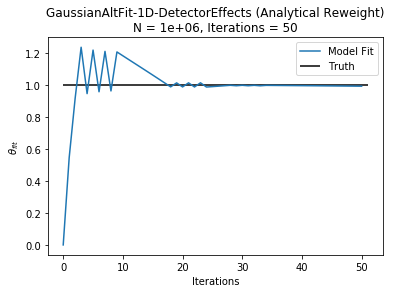

In [25]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(theta1_param, 0, len(fit_vals), label='Truth')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("GaussianAltFit-1D-DetectorEffects (Analytical Reweight)\n" +
          "N = {:.0e}, Iterations = {:.0f}".format(N, iterations))
# plt.savefig("GaussianAltFit-1D-DetectorEffects (Analytical Reweight)" +
#             "N = {:.0e}, Iterations = {:.0f}.png".format(N, iterations))
plt.show()

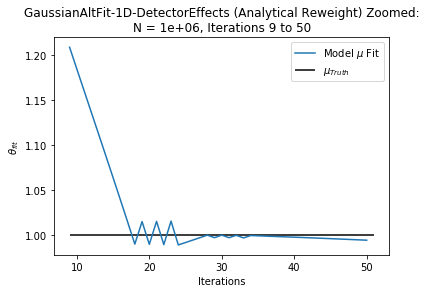

In [26]:
# Zoom into later iterations (finer fit)
fit_vals = np.array(fit_vals)
plt.title("GaussianAltFit-1D-DetectorEffects (Analytical Reweight) Zoomed:\n" +
          "N = {:.0e}, Iterations {:.0f} to {:.0f}".format(
              N, index_refine[1], iterations))
plt.plot(np.arange(index_refine[1], len(fit_vals)),
         fit_vals[index_refine[1]:],
         label='Model $\mu$ Fit')
plt.hlines(theta1_param, index_refine[1], len(fit_vals), label='$\mu_{Truth}$')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig("GaussianAltFit-1D-DetectorEffects (Analytical Reweight) Zoomed:" +
#             "N = {:.0e}, Iterations {:.0f} to {:.0f}.png".format(
#                 N, index_refine[1], iterations))
plt.show()